#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Импортируем необходимые библиотеки.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings('ignore')

Откроем наш датасет и изучим его.

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


Выполним ресемплирование данных по одному часу.

In [4]:
data_res=data.resample('1H').sum()
data_res=data_res.sort_index(ascending=True)
data_res.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [5]:
data_res.index.year.value_counts()

2018    4416
Name: datetime, dtype: int64

Данные предоставлены только за 2018г. Переходим к следующему этапу.

## Анализ

Посмотрим, как выглядят наши данные.

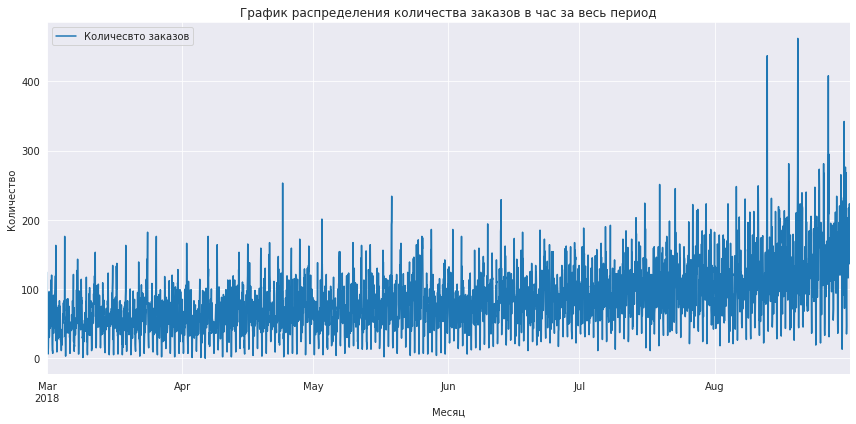

In [6]:
sns.set_style('darkgrid')
data_res.plot(ax=plt.gca(),figsize=(12,6))
plt.legend(['Количесвто заказов'])
plt.title('График распределения количества заказов в час за весь период')
plt.xlabel('Месяц')
plt.ylabel('Количество')
plt.tight_layout()
plt.show()

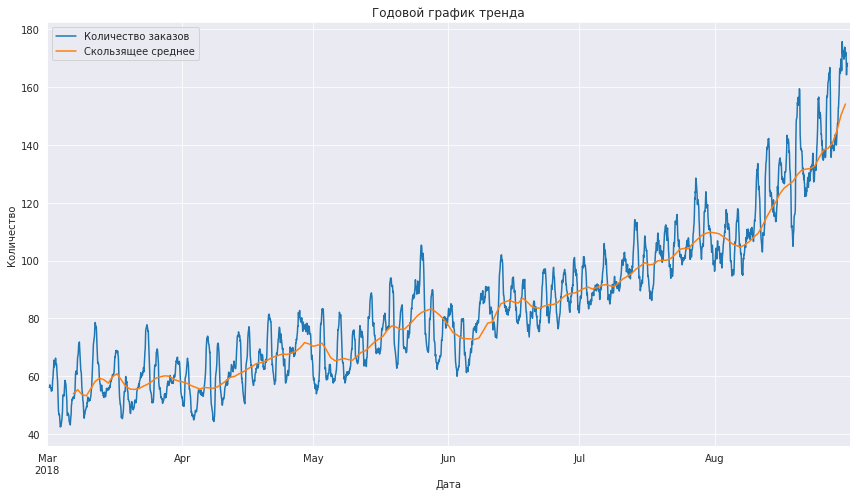

In [7]:
decomposed=seasonal_decompose(data_res)
decomposed.trend.plot(ax=plt.gca(),figsize=(12,6))
decomposed.trend.resample('1D').mean().rolling(7).mean().plot(ax=plt.gca(),figsize=(12,7))
plt.legend(['Количество заказов', 'Скользящее среднее'])
plt.title('Годовой график тренда')
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.tight_layout()

По графику видно, что среднее количеситво заказов растет от месяца к месяцу. Со временем все больше и больше людей пользуется услугой заказа такси.

* Взглянем на дневное распределение заказов

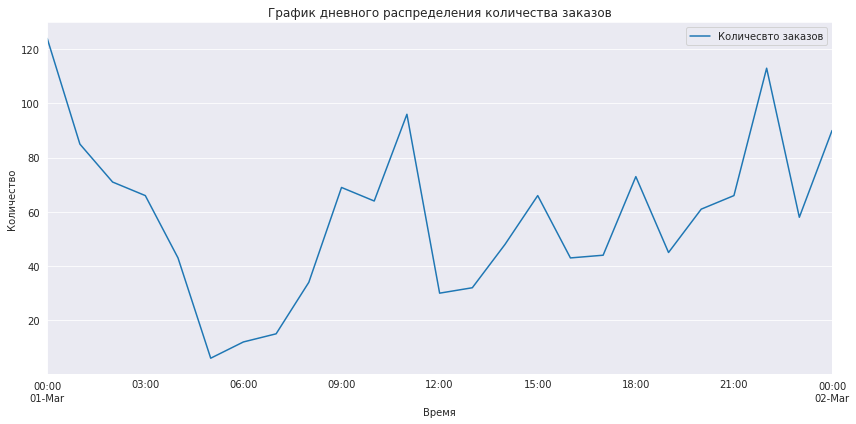

In [8]:
data_res['2018-03-01 00:00:00':'2018-03-02 00:00:00'].plot(ax=plt.gca(),figsize=(12,6))
plt.legend(['Количесвто заказов'])
plt.title('График дневного распределения количества заказов')
plt.xlabel('Время')
plt.ylabel('Количество')
plt.tight_layout()
plt.show()

По графику видим, что к вечеру количество заказов возростает, а после 2х часов ночи резко падает. Есть утренние и вечерние всплески спроса. В будещем нам потребуется признак hour.

* Выполним декомпозицию и посмотим на тренды и сезонность в разрезе недели и месяца.

In [9]:
decomposed_week = seasonal_decompose(data_res['2018-03-05':'2018-03-12'])
decomposed_month = seasonal_decompose(data_res.resample('1D').sum()['2018-03-05':'2018-04-02'])

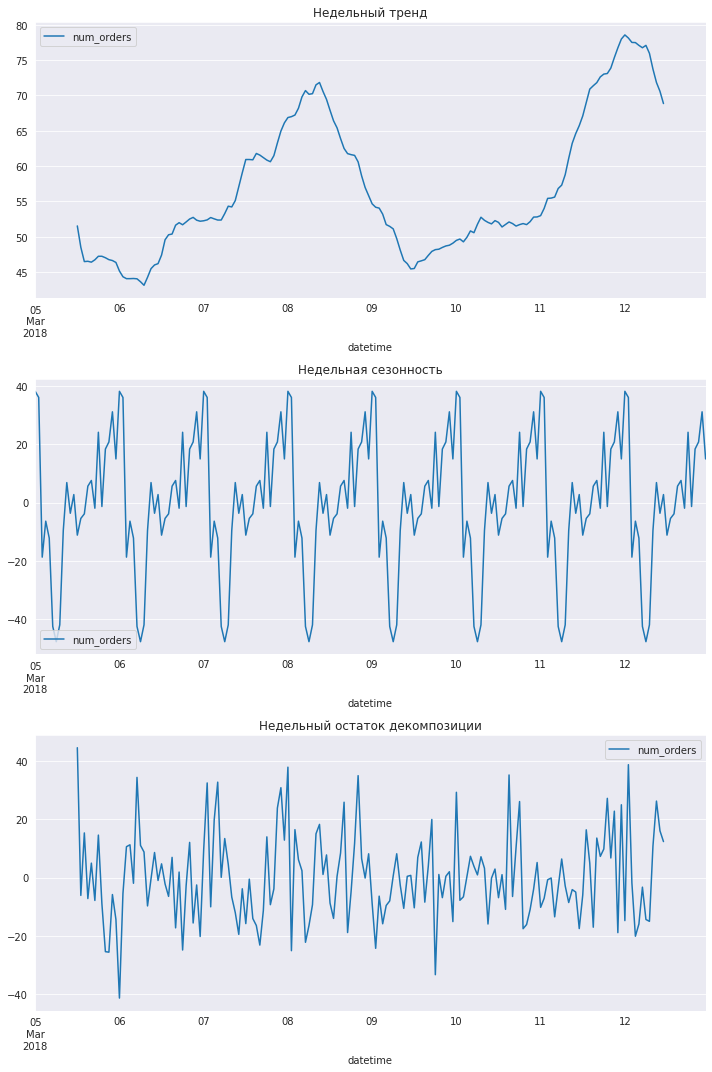

In [10]:
plt.figure(figsize=(10,15))
plt.subplot(311)
decomposed_week.trend.plot(ax=plt.gca())
plt.title('Недельный тренд')
plt.subplot(312)
decomposed_week.seasonal.plot(ax=plt.gca())
plt.title('Недельная сезонность')
plt.subplot(313)
decomposed_week.resid.plot(ax=plt.gca())
plt.title('Недельный остаток декомпозиции')
plt.tight_layout()

Недельный тренд показывает, что к концу недели и в середине идет увеличение заказов. В будущем нам потребуется признак dayofweek.  
Так же видна ежедневная сезонность - понадобится признак day.

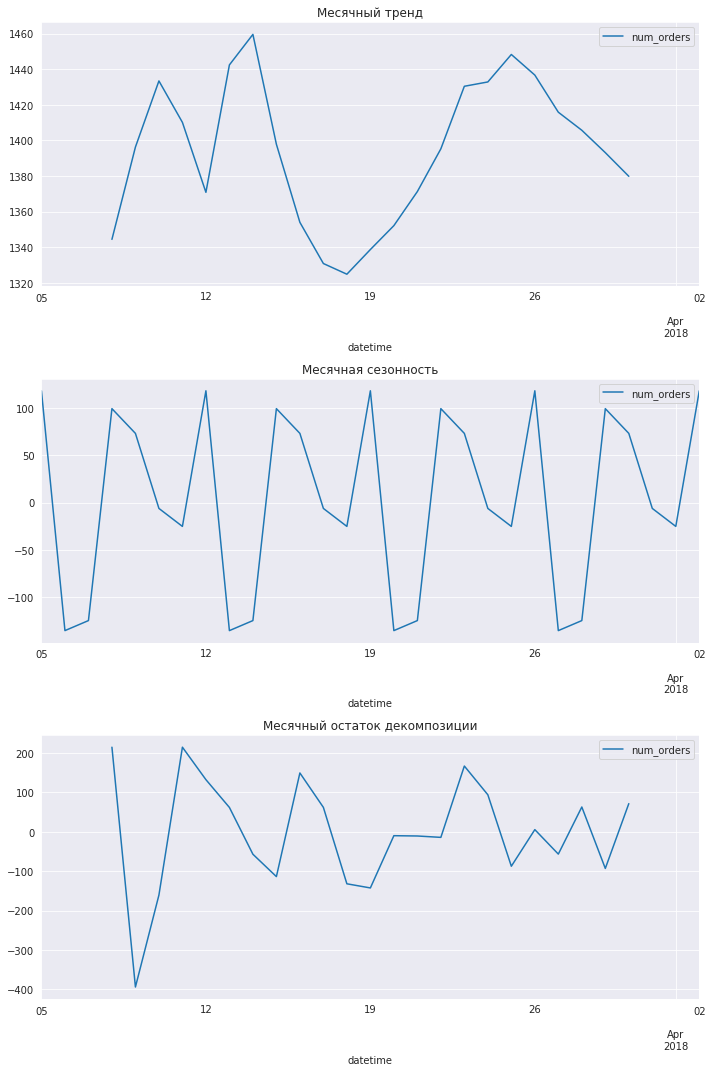

In [11]:
plt.figure(figsize=(10,15))
plt.subplot(311)
decomposed_month.trend.plot(ax=plt.gca())
plt.title('Месячный тренд')
plt.subplot(312)
decomposed_month.seasonal.plot(ax=plt.gca())
plt.title('Месячная сезонность')
plt.subplot(313)
decomposed_month.resid.plot(ax=plt.gca())
plt.title('Месячный остаток декомпозиции')
plt.tight_layout()

Из месяца в месяц данные отличаются и носят цикличный характер. В будущем нам потребуется признак month.

## Обучение

* Добавим в нашу выборку дополнительные признаки, отстающие значения и скользящее среднее.  

In [12]:
def make_features(data, max_lag, rolling_mean_size):
    #data['year'] = data.index.year
    #data['month'] = data.index.month
    #data['day'] = data.index.day
    data['hour']= data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

Подберем оптимальные параметры модели:

In [13]:
make_features(data_res, 1, 24)
data_res.head()

,num_orders,hour,dayofweek,lag_1,rolling_mean
datetime,,,,,
2018-03-01 00:00:00,124,0,3,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN
2018-03-01 02:00:00,71,2,3,85.0,NaN
2018-03-01 03:00:00,66,3,3,71.0,NaN
2018-03-01 04:00:00,43,4,3,66.0,NaN


Определим тестовую и тренировочную выборку

In [14]:
train,test=train_test_split(data_res, shuffle=False, test_size=0.1)

# Удалим отсутствующие значения из тренировочных данных, которые образовались в результате сдвига
train = train.dropna()

Определим целевой признак

In [15]:
train_features=train.drop('num_orders',axis=1)
train_target=train['num_orders']

test_features=test.drop('num_orders',axis=1)
test_target=test['num_orders']

#Проверим разбиение 
print('Размер тренировочной выборки- {:.0%}'.format(train_features.shape[0]/data_res.shape[0]))
print('Размер тестовой выборки - {:.0%}'.format(test_target.shape[0]/data_res.shape[0]))

Размер тренировочной выборки- 89%
Размер тестовой выборки - 10%


* Напишем функцию для расчета целевой метрики RMSE

In [16]:
def rmse(test,predict):
    return ((mean_squared_error(test,predict))**0.5).round(2)

* Обучим модель **LinearRegression**

In [17]:
model_lr=LinearRegression(normalize=True)
model_lr.fit(train_features,train_target)
predict_lr=model_lr.predict(test_features)
predict_lr=predict_lr.round()
mae_lr=mean_absolute_error(test_target, predict_lr)
print('MAE модели Линейная Регрессия равна:',mae_lr.round(2))
rmse_lr=rmse(test_target, predict_lr)
print('RMSE модели Линейная Регрессия равна:', rmse_lr)

MAE модели Линейная Регрессия равна: 38.83
RMSE модели Линейная Регрессия равна: 51.19


* Обучим модель **RandomForestRegressor**

In [18]:
# Подберем гиперпараметры модели:
parametrs = { 'n_estimators': range (5, 20),
              'max_depth': range (10, 20)}
split_index = TimeSeriesSplit().split(train_features)
model_rf = RandomForestRegressor(random_state=42)
grid_rf = GridSearchCV(model_rf, parametrs, cv=split_index, scoring=make_scorer(rmse, greater_is_better=False))
grid_rf.fit(train_features, train_target)

best_score_rf = -1*grid_rf.best_score_

parametrs_r_gs_d=pd.Series(grid_rf.best_params_)[0]
parametrs_r_gs_n=pd.Series(grid_rf.best_params_)[1]
print('Значение RMSE на обучающей выборке равно: {:.2f}'
      .format(best_score_rf), '\nМаксимальная глубина:',parametrs_r_gs_d, '\nКоличество деревьев:',parametrs_r_gs_n)

Значение RMSE на обучающей выборке равно: 28.08 
Максимальная глубина: 17 
Количество деревьев: 16


In [19]:
predict_rf=grid_rf.predict(test_features)
predict_rf=predict_rf.round()

# Вычислим MAE и RMSE
mae_rf=mean_absolute_error(test_target, predict_rf)
print('MAE модели Случайный лес равна:',mae_rf.round(2))
rmse_rf=rmse(test_target, predict_rf)
print('RMSE модели Случайный лес равна:', rmse_rf)

MAE модели Случайный лес равна: 33.22
RMSE модели Случайный лес равна: 45.12


* Обучим модель **CatBoostRegressor**

In [20]:
model_cat = CatBoostRegressor(random_state=42, learning_rate=0.4, verbose=100, n_estimators=300)
model_cat.fit(train_features, train_target, eval_set=(test_features,test_target))
predict_cat=model_cat.predict(test_features)
predict_cat=predict_cat.round()

0:	learn: 32.1040840	test: 74.2517323	best: 74.2517323 (0)	total: 49.6ms	remaining: 14.8s
100:	learn: 16.9691866	test: 45.5819500	best: 44.3552840 (32)	total: 1.61s	remaining: 3.17s
200:	learn: 14.3617539	test: 45.2129654	best: 44.3552840 (32)	total: 3.16s	remaining: 1.56s
299:	learn: 12.6824308	test: 46.2845150	best: 44.3552840 (32)	total: 4.81s	remaining: 0us

bestTest = 44.35528403
bestIteration = 32

Shrink model to first 33 iterations.


In [21]:
mae_cat=mean_absolute_error(test_target, predict_cat).round(2)
print('MAE модели Случайный лес равна:',mae_cat)
rmse_cat=rmse(test_target, predict_cat)
print('RMSE модели Случайный лес равна:', rmse_cat)

MAE модели Случайный лес равна: 33.17
RMSE модели Случайный лес равна: 44.36


* Объединим получившиеся результаты в одну таблицу

In [22]:
column=['RMSE модели','MAE модели']

comparison_tabl = pd.DataFrame(
    index=['RMSE модели','MAE модели',], columns=['LinearRegression','RandomForestRegressor','CatBoostRegressor'])
comparison_tabl['LinearRegression'] = rmse_lr, mae_lr
comparison_tabl['RandomForestRegressor'] = rmse_rf, mae_rf
comparison_tabl['CatBoostRegressor'] = rmse_cat,mae_cat

comparison_tabl.T.style.highlight_min(color='yellowgreen',subset=column).highlight_null(
    null_color='lightgrey').highlight_max(color='coral',subset=column)

,RMSE модели,MAE модели
LinearRegression,51.19,38.8281
RandomForestRegressor,45.12,33.2217
CatBoostRegressor,44.36,33.17


*Мы добавили в наши данные признаки по дате события включая день недели и час. А так же добавили 1 столбец со сдвигом целевой метки и скользящее среднее значение с окном в 24 часа. Благодаря этому нам удалось достичь необходимого качества предсказания, на обучаемых моделях. Самый лучший результат показала модель CatBoostRegressor.*

## Тестирование

* Посмотрим значения предсказания наилучшей модели на графиках и сравним с целевыми

Преобразуем предсказания в серию с присвоением индексов времени

In [23]:
pred_data= pd.Series(predict_cat, index=test_features.index)
pred_data.head()

datetime
2018-08-13 14:00:00    108.0
2018-08-13 15:00:00    112.0
2018-08-13 16:00:00    145.0
2018-08-13 17:00:00    131.0
2018-08-13 18:00:00     93.0
Freq: H, dtype: float64

Построим график за целевой период времени и нанесём на него скользящие средние значения

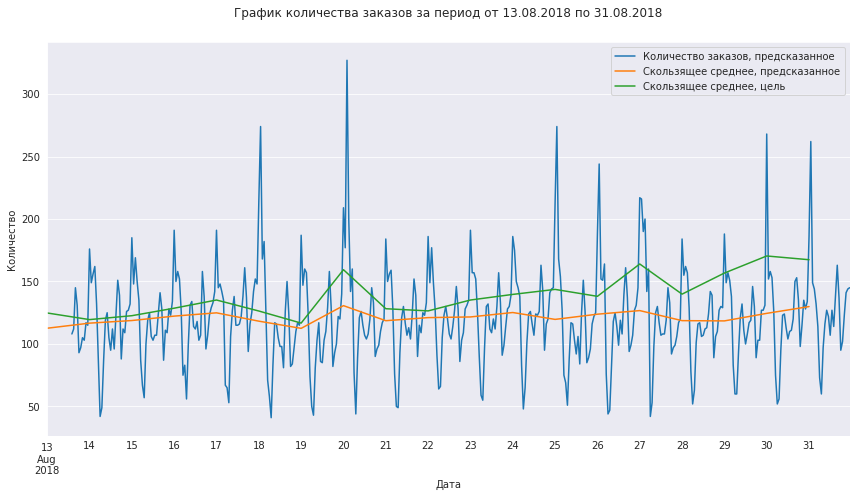

In [24]:
pred_data.plot(ax=plt.gca(),figsize=(12,7))
pred_data.resample('1D').mean().rolling(1).mean().plot(ax=plt.gca(),figsize=(12,7))
test_target.resample('1D').mean().rolling(1).mean().plot(ax=plt.gca(),figsize=(12,7))
plt.legend(['Количество заказов, предсказанное', 'Скользящее среднее, предсказанное', 'Скользящее среднее, цель'])
plt.title('График количества заказов за период от 13.08.2018 по 31.08.2018', y=1.05)
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.tight_layout()

График цикличный и повторяется ежедневно, возьмём период за один день

* Посмотрим на временной период одного дня с распределением по часам и на предсказания нашей лучшей модели CatBoostRegressor

In [25]:
day1='2018-08-15 00:00:00'
day2='2018-08-15 23:00:00'

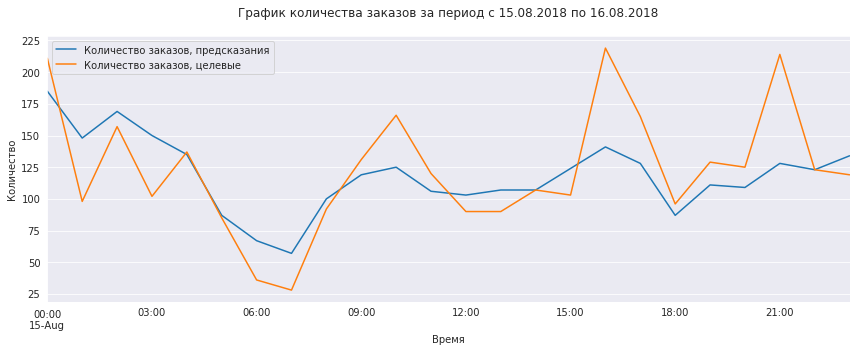

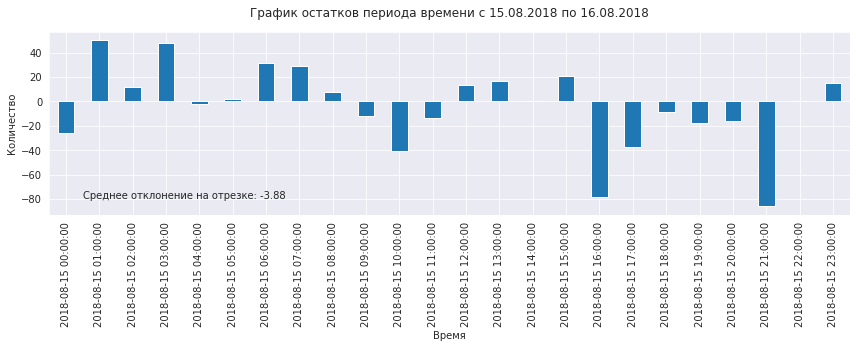

In [26]:
pred_data[day1:day2].plot(ax=plt.gca(),figsize=(12,5))
test_target[day1:day2].plot(ax=plt.gca(),figsize=(12,5))

plt.legend(['Количество заказов, предсказания', 'Количество заказов, целевые'])
plt.title('График количества заказов за период c 15.08.2018 по 16.08.2018', y=1.05)
plt.xlabel('Время')
plt.ylabel('Количество')
plt.tight_layout()
plt.subplots()

test_featuresy=test_features.copy()
test_featuresy['Test_CAT']=predict_cat-test_target
test_featuresy[day1:day2]['Test_CAT'].plot(kind='bar',ax=plt.gca(),figsize=(12,5))
plt.title('График остатков периода времени c 15.08.2018 по 16.08.2018', y=1.05)
plt.text(0.5,-80,'Среднее отклонение на отрезке: {:.2f}'.format(test_featuresy[day1:day2]['Test_CAT'].mean()))
plt.xlabel('Время')
plt.ylabel('Количество')
plt.tight_layout()

*Наша модель хорошо справляется с задачей предсказывать количество заказов с разбивкой по часам. На часовом графике это видно: мы можем наблюдать спад заказов с 4 до 7 часов утра и пиковые значения в утренние и вечерние часы.  
Модель CatBoostRegressor имеет пороговое значение метрики RMSE = 44.36, что удовлетворяет условиям проекта. Данная модель может быть использована компанией "Чётенькое такси" для предсказания количества заказов на следующий час.* 